In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from lightgbm import LGBMClassifier
import shap


d:\Final_Year_Project\Hybrid_Anomaly_Detection\netenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Load KDDCup Dataset

kdd = pd.read_csv(r"D:\Final_Year_Project\Hybrid_Anomaly_Detection\processed_data\kddcup_data_cleaned.csv")

X = kdd.drop("label", axis=1)
y = kdd["label"]

feature_names = X.columns


In [5]:
# Split into Train and Test Sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
# Feature Scaling for lightGBM (SVM will be trained on unscaled data)

scaler_full_kdd = StandardScaler()

X_train_scaled = scaler_full_kdd.fit_transform(X_train)
X_test_scaled = scaler_full_kdd.transform(X_test)


In [7]:
# Train lightGBM Classifier


lgb_model_kdd = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

lgb_model_kdd.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 46229, number of negative: 70239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 116468, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.396924 -> initscore=-0.418296
[LightGBM] [Info] Start training from score -0.418296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,8
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [8]:
# Feature Importance Analysis for lightGBM

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lgb_model_kdd.feature_importances_
}).sort_values(by="Importance", ascending=False)

threshold = importance_df["Importance"].mean()

top_features_kdd = importance_df[importance_df["Importance"] > threshold]["Feature"].tolist()

print("KDD Selected Features:", top_features_kdd)


KDD Selected Features: ['src_bytes', 'dst_bytes', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'duration', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_count', 'dst_host_srv_diff_host_rate', 'hot', 'count', 'dst_host_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'same_srv_rate', 'service_private', 'service_http', 'srv_count', 'protocol_type_icmp', 'service_ftp_data', 'wrong_fragment', 'logged_in', 'protocol_type_tcp', 'service_domain_u', 'service_telnet', 'flag_SF']


In [9]:
#reduce feature set for both train and test data

X_train_selected = X_train[top_features_kdd]
X_test_selected = X_test[top_features_kdd]


In [10]:
# Feature Scaling for SVM (using only selected features)

scaler_kdd = StandardScaler()

X_train_selected = scaler_kdd.fit_transform(X_train_selected)
X_test_selected = scaler_kdd.transform(X_test_selected)


In [11]:
#train SVM on selected features

svm_model_kdd = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm_model_kdd.fit(X_train_selected, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",10
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [12]:
# Evaluate SVM on Test Set on KDDCUP Dataset

y_pred_kdd = svm_model_kdd.predict(X_test_selected)

print("----- KDD RESULTS -----")
print("Accuracy:", accuracy_score(y_test, y_pred_kdd))
print("Precision:", precision_score(y_test, y_pred_kdd))
print("Recall:", recall_score(y_test, y_pred_kdd))
print("F1 Score:", f1_score(y_test, y_pred_kdd))


----- KDD RESULTS -----
Accuracy: 0.9987636088882783
Precision: 0.998265093684941
Recall: 0.9986115931968067
F1 Score: 0.9984383133784487


In [13]:
print("Train Accuracy:", svm_model_kdd.score(X_train_selected, y_train))
print("Test Accuracy:", svm_model_kdd.score(X_test_selected, y_test))


Train Accuracy: 0.9990297764192739
Test Accuracy: 0.9987636088882783


In [2]:
import shap
explainer_kdd = shap.TreeExplainer(lgb_model_kdd)

shap_values_kdd = explainer_kdd.shap_values(X_train_scaled)

shap.summary_plot(shap_values_kdd, X_train_scaled, feature_names=feature_names)

d:\Final_Year_Project\Hybrid_Anomaly_Detection\netenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'lgb_model_kdd' is not defined

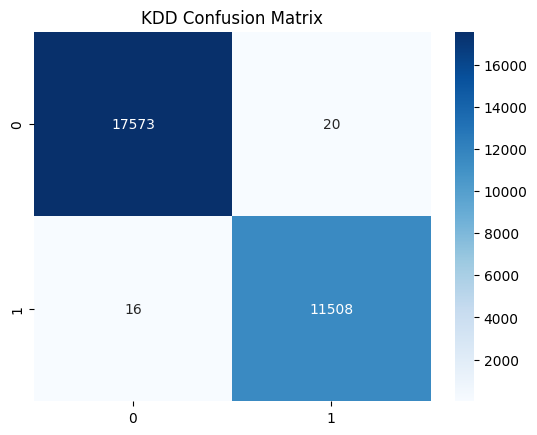

KDD AUC: 0.9999727831071306


In [14]:
cm_kdd = confusion_matrix(y_test, y_pred_kdd)

sns.heatmap(cm_kdd, annot=True, fmt='d', cmap='Blues')
plt.title("KDD Confusion Matrix")
plt.show()
y_prob_kdd = svm_model_kdd.predict_proba(X_test_selected)[:, 1]
fpr_kdd, tpr_kdd, _ = roc_curve(y_test, y_prob_kdd)
roc_auc_kdd = auc(fpr_kdd, tpr_kdd) 
print("KDD AUC:", roc_auc_kdd)



########################################################



                    NSL-KDD PIPELINE

In [15]:
#loading the data again for training lightGBM and SVM on the full feature set (for comparison)

train_df = pd.read_csv(r"D:\Final_Year_Project\Hybrid_Anomaly_Detection\processed_data\kdd_train_cleaned.csv")
test_df = pd.read_csv(r"D:\Final_Year_Project\Hybrid_Anomaly_Detection\processed_data\kdd_test_cleaned.csv")

X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

feature_names = X_train.columns


In [16]:
#scale full feature 

scaler_full_nsl = StandardScaler()

X_train_scaled = scaler_full_nsl.fit_transform(X_train)
X_test_scaled = scaler_full_nsl.transform(X_test)


In [17]:
#lightGBM on full feature set

lgb_model_nsl = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

lgb_model_nsl.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 58622, number of negative: 67342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3333
[LightGBM] [Info] Number of data points in the train set: 125964, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465387 -> initscore=-0.138674
[LightGBM] [Info] Start training from score -0.138674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,8
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [18]:
#feature importance for lightGBM on full feature set

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lgb_model_nsl.feature_importances_
}).sort_values(by="Importance", ascending=False)

threshold = importance_df["Importance"].mean()

top_features_nsl = importance_df[importance_df["Importance"] > threshold]["Feature"].tolist()

print("NSL Selected Features:", top_features_nsl)


NSL Selected Features: ['src_bytes', 'dst_host_srv_count', 'dst_host_count', 'dst_bytes', 'dst_host_diff_srv_rate', 'duration', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_rerror_rate', 'count', 'hot', 'service_private', 'dst_host_serror_rate', 'dst_host_srv_diff_host_rate', 'srv_count', 'dst_host_srv_serror_rate', 'diff_srv_rate', 'protocol_type_icmp', 'service_http', 'service_ecr_i', 'service_ftp_data', 'logged_in', 'dst_host_srv_rerror_rate', 'service_domain_u', 'same_srv_rate', 'protocol_type_tcp']


In [19]:
#reduce feature set for both train and test data

X_train_selected = X_train[top_features_nsl]
X_test_selected = X_test[top_features_nsl]


In [20]:
#scale the full feature set for lightGBM

scaler_nsl = StandardScaler()

X_train_selected = scaler_nsl.fit_transform(X_train_selected)
X_test_selected = scaler_nsl.transform(X_test_selected)


In [21]:
#train SVM on selected features

svm_model_nsl = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm_model_nsl.fit(X_train_selected, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",10
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [22]:
#evaluate nsl model


y_pred_nsl = svm_model_nsl.predict(X_test_selected)

print("----- NSL RESULTS -----")
print("Accuracy:", accuracy_score(y_test, y_pred_nsl))
print("Precision:", precision_score(y_test, y_pred_nsl))
print("Recall:", recall_score(y_test, y_pred_nsl))
print("F1 Score:", f1_score(y_test, y_pred_nsl))


----- NSL RESULTS -----
Accuracy: 0.9252129169623847
Precision: 0.9885150929972558
Recall: 0.8607841401893973
F1 Score: 0.9202384331535624


In [24]:
print(lgb_model_kdd)
print(svm_model_kdd)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=8,
               n_estimators=200, random_state=42, reg_alpha=0.1, reg_lambda=0.1,
               subsample=0.8)
SVC(C=10, class_weight='balanced', probability=True, random_state=42)


In [27]:
#models


import joblib

joblib.dump(lgb_model_kdd, "models/lgb_kdd.pkl")
joblib.dump(svm_model_kdd, "models/svm_kdd.pkl")

joblib.dump(lgb_model_nsl, "models/lgb_nsl.pkl")
joblib.dump(svm_model_nsl, "models/svm_nsl.pkl")
print("All models trained successfully.")

All models trained successfully.


In [ ]:
import joblib
joblib.dump(top_features_nsl, "models/features_nsl.pkl")

['models/features_nsl.pkl']

In [29]:
joblib.dump(top_features_kdd, "models/features_kdd.pkl")

['models/features_kdd.pkl']